Time embedding added after each down sampling convolution

In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import vmap

from flax import nnx
from functools import partial

import tensorflow_datasets as tfds
# import tensorflow as tf

In [2]:
# define and init models
rngs = nnx.Rngs(0)

class Unet(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        n_features = [1, 64, 64, 128, 256]
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.relu
        self.do = nnx.Dropout(0., rngs=rngs)

        # fully connected nn for time embedding
        self.dense1 = nnx.Linear(1, 16, rngs=rngs)
        self.dense2 = nnx.Linear(16, 1, rngs=rngs)
        
        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # Initial
        in_features = n_features[0]
        
        # Downsampling
        self.down = []
        for out_features in n_features[1:-1]:

            # append convolutional layer
            self.down.append(nnx.Conv(in_features, out_features, 
                                      kernel_size=kernel_size, 
                                      padding=padding, 
                                      strides=c_strides,
                                      rngs=rngs))

            # update in features
            in_features = out_features

        # Embedding
        self.embed = nnx.Conv(in_features, n_features[-1], 
                              kernel_size=kernel_size, 
                              padding=padding, 
                              strides=c_strides,
                              rngs=rngs)
        in_features = n_features[-1]
        
        # Upsampling
        self.up = []
        for out_features in reversed(n_features[1:-1]):

            # block includes up sampling + convolution 
            up_block = []
            
            # transpose convolutional layer
            up_block.append(nnx.ConvTranspose(in_features, out_features, 
                                              kernel_size=kernel_size, 
                                              padding=padding, 
                                              strides=p_strides, 
                                              rngs=rngs))
          
            # convolutional layer
            up_block.append(nnx.Conv(2 * out_features, out_features, 
                                     kernel_size=kernel_size, 
                                     padding=padding, 
                                     strides=c_strides, 
                                     rngs=rngs))

            # update in features
            in_features = out_features

            # append block
            self.up.append(up_block)

        # Final
        self.outconv = nnx.Conv(in_features, n_features[0], kernel_size=(1, 1), rngs=rngs)

    def temb(self, t):

        # pass through net
        return self.dense2(nnx.tanh(self.dense1(t)))[:, jnp.newaxis, jnp.newaxis, :]
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x, t):

        # downsample
        save = []
        for down in self.down:
            
            # convolution + activation + dropout
            x = self.convnet(x, down)

            # time embedding
            x = x + self.temb(t)
            
            # save context
            save.append(x)
            
            # pooling layer
            x = self.pool(x)

        # convolution + activation + dropout
        x = self.convnet(x, self.embed)

        # time embedding
        # x = x + self.temb(t)

        # upsample
        for up, x_i in zip(self.up, reversed(save)):

            # transpose convolution
            x = self.convnet(x, up[0])
            
            # concat and convolve
            x = self.convnet(jnp.concatenate([x, x_i], -1), up[1])

        # n_features -> n_channels 
        x = self.outconv(x)

        return x

# Initialize the model
unet_model = Unet(rngs)

In [3]:
params = nnx.state(unet_model, nnx.Param)
total_params = np.sum([np.size(x) for x in jax.tree.leaves(params)])
total_params

np.int64(1255090)

### Import data

In [1]:
# import MNIST (test set with 10000 samples)
X, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

# resize to be 32x32
img_size = 32
D = np.zeros([len(X), img_size, img_size, 1])
for i, x in enumerate(X):
    D[i,:,:,0] = cv2.resize(x[:,:,0], (img_size, img_size), interpolation=cv2.INTER_AREA)

In [5]:
# scale data
D_mean = np.mean(D)
D_stdv = np.std(D)
D = (D - D_mean) / D_stdv

# random shuffling of sample index
N = len(D)
order = np.arange(N)
np.random.shuffle(order)

### Define parameters for diffusion process

In [6]:
# define diffusion parameters 

# number of steps
T = 1000
steps = np.arange(T)

# beta
# beta_t = .005 * np.ones(T)
beta_t = np.linspace(.0001, .02, T)
# beta_t = np.linspace(.001, .01, T)

# function to compute alpha_t
alpha_t = lambda t: jnp.prod(1. - beta_t[jnp.arange(t+1)])

# number of training epochs
n_epochs = 100

# batch size
n_batch = 8
n_batches = len(np.array_split(order, np.ceil(N / n_batch)))

### Train diffusion model 

In [7]:
import optax

learning_rate = 0.0001
momentum = 0.9
weight_decay = .0001

optimizer = nnx.Optimizer(unet_model, optax.adam(learning_rate))
# optimizer = nnx.Optimizer(unet_model, optax.adamw(learning_rate, weight_decay = weight_decay))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

In [8]:
def loss_fn(model: Unet, eps, batch_z_t, batch_t):

    # predict noise
    eps_pred = model(batch_z_t, batch_t)

    # return mean squared difference
    loss = jnp.mean((eps - eps_pred) ** 2)
    
    return loss

In [9]:
@nnx.jit
def train_step(model: Unet, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, eps, batch_z_t, batch_t):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, eps, batch_z_t, batch_t)
    metrics.update(loss=loss)
    optimizer.update(grads)
    return loss

In [10]:
@nnx.jit
def mu_t(model, z, t, w1, w2):

    # compute mu_t 
    return jnp.einsum('i,ijkl->ijkl', w2, z - jnp.einsum('i,ijkl->ijkl', w1, model(z, t)))

# function to sample from latent space
def generate(model, n, temp=1.):
    
    # generate samples
    z = temp * np.random.randn(*D[[0]*n].shape)
    
    # compute chain
    for t in reversed(steps):
    
        # update z 
        if t > 0:
    
            # compute mu_t 
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            
            # sample noise
            eps = temp * np.random.randn(*z.shape) 
            z = mu_t(model, z, batch_steps, w1, w2) + np.einsum('i,ijkl->ijkl', np.array(n * [np.sqrt(beta_t[t])]), eps)
    
        # don't add noise at final step 
        else:
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            z = mu_t(unet_model, z, batch_steps, w1, w2)

    return z

Epoch 1, Loss: 0.09853
Epoch 2, Loss: 0.05876
Epoch 3, Loss: 0.04929
Epoch 4, Loss: 0.04550
Epoch 5, Loss: 0.04388
Epoch 6, Loss: 0.04325
Epoch 7, Loss: 0.04034
Epoch 8, Loss: 0.03981
Epoch 9, Loss: 0.03995
Epoch 10, Loss: 0.03977


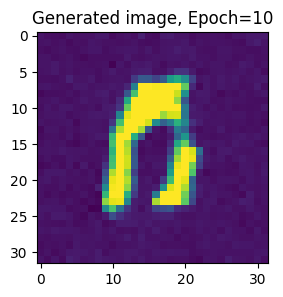

Epoch 11, Loss: 0.03687
Epoch 12, Loss: 0.03751
Epoch 13, Loss: 0.03536
Epoch 14, Loss: 0.03585
Epoch 15, Loss: 0.03438
Epoch 16, Loss: 0.03506
Epoch 17, Loss: 0.03394
Epoch 18, Loss: 0.03428
Epoch 19, Loss: 0.03364
Epoch 20, Loss: 0.03285


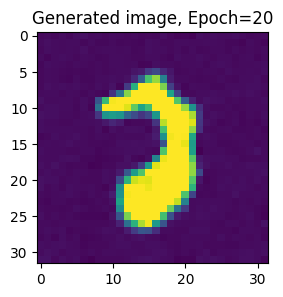

Epoch 21, Loss: 0.03314
Epoch 22, Loss: 0.03275
Epoch 23, Loss: 0.03258
Epoch 24, Loss: 0.03203
Epoch 25, Loss: 0.03140
Epoch 26, Loss: 0.03104
Epoch 27, Loss: 0.03142
Epoch 28, Loss: 0.03110
Epoch 29, Loss: 0.03256
Epoch 30, Loss: 0.03140


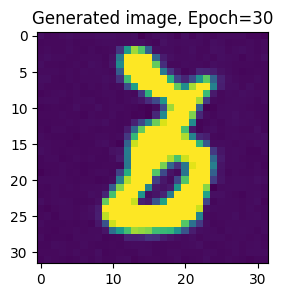

Epoch 31, Loss: 0.03089
Epoch 32, Loss: 0.03014
Epoch 33, Loss: 0.02969
Epoch 34, Loss: 0.03099
Epoch 35, Loss: 0.02992
Epoch 36, Loss: 0.02997
Epoch 37, Loss: 0.02988
Epoch 38, Loss: 0.03084
Epoch 39, Loss: 0.03019
Epoch 40, Loss: 0.02965


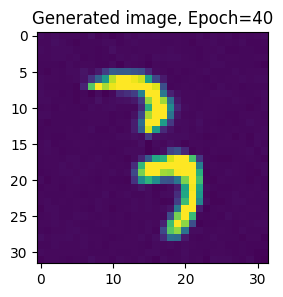

Epoch 41, Loss: 0.02920
Epoch 42, Loss: 0.02801
Epoch 43, Loss: 0.02896
Epoch 44, Loss: 0.02978
Epoch 45, Loss: 0.02902
Epoch 46, Loss: 0.02900
Epoch 47, Loss: 0.02873
Epoch 48, Loss: 0.02890
Epoch 49, Loss: 0.02889
Epoch 50, Loss: 0.02902


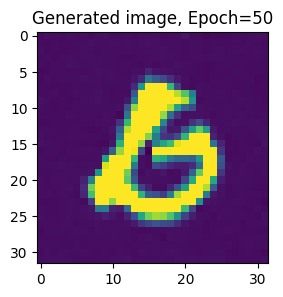

Epoch 51, Loss: 0.02747
Epoch 52, Loss: 0.02840
Epoch 53, Loss: 0.02877
Epoch 54, Loss: 0.02772
Epoch 55, Loss: 0.02777
Epoch 56, Loss: 0.02717
Epoch 57, Loss: 0.02698
Epoch 58, Loss: 0.02799
Epoch 59, Loss: 0.02765
Epoch 60, Loss: 0.02713


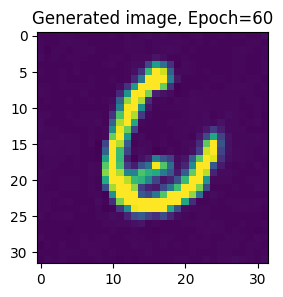

Epoch 61, Loss: 0.02769
Epoch 62, Loss: 0.02772
Epoch 63, Loss: 0.02800
Epoch 64, Loss: 0.02685
Epoch 65, Loss: 0.02835
Epoch 66, Loss: 0.02698
Epoch 67, Loss: 0.02744
Epoch 68, Loss: 0.02683
Epoch 69, Loss: 0.02704
Epoch 70, Loss: 0.02711


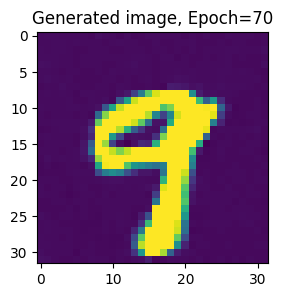

Epoch 71, Loss: 0.02746
Epoch 72, Loss: 0.02683
Epoch 73, Loss: 0.02695
Epoch 74, Loss: 0.02677
Epoch 75, Loss: 0.02683
Epoch 76, Loss: 0.02611
Epoch 77, Loss: 0.02617
Epoch 78, Loss: 0.02581
Epoch 79, Loss: 0.02642
Epoch 80, Loss: 0.02637


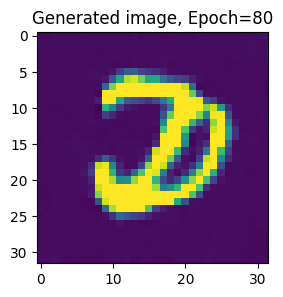

Epoch 81, Loss: 0.02691
Epoch 82, Loss: 0.02611
Epoch 83, Loss: 0.02690
Epoch 84, Loss: 0.02607
Epoch 85, Loss: 0.02571
Epoch 86, Loss: 0.02612
Epoch 87, Loss: 0.02512
Epoch 88, Loss: 0.02648
Epoch 89, Loss: 0.02592
Epoch 90, Loss: 0.02595


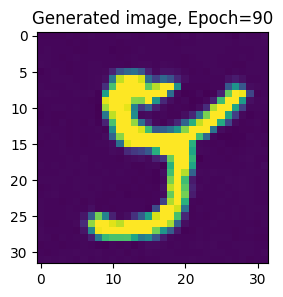

Epoch 91, Loss: 0.02566
Epoch 92, Loss: 0.02638
Epoch 93, Loss: 0.02564
Epoch 94, Loss: 0.02516
Epoch 95, Loss: 0.02641
Epoch 96, Loss: 0.02504
Epoch 97, Loss: 0.02586
Epoch 98, Loss: 0.02637
Epoch 99, Loss: 0.02563
Epoch 100, Loss: 0.02560


In [11]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
unet_model.train() 
for epoch in range(n_epochs):

    # sample image
    if epoch>0 and epoch%10 == 0:

        # sample from latent space
        unet_model.eval() 
        z = generate(unet_model, n=1)
        unet_model.train() 

        # rescale
        z = jnp.clip((77.3461 * z) + 96.9685, 0., 255.)

        plt.figure(figsize=(3, 3))
        plt.imshow(z[0])
        plt.title(f"Generated image, Epoch={epoch}")
        plt.show()
    
    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    epoch_loss = 0
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):
    
        # get data batch
        batch_D = D[batch_inds]
        
        # randomly sample steps
        batch_steps = np.random.choice(steps, len(batch_D)) 
        
        # diffusion kernel parameters
        A_t = np.array([alpha_t(t) for t in batch_steps])

        # sample Gaussian noise
        eps = np.random.randn(*batch_D.shape)
        
        # sample from diffusion kernel 
        e_t = np.einsum('i,ijkl->ijkl', np.sqrt(1. - A_t), eps)
        batch_z_t = np.einsum('i,ijkl->ijkl', np.sqrt(A_t), batch_D) + e_t

        # scale batch steps for input to model
        batch_steps_scaled = jnp.vstack(batch_steps) / (T - 1)
        
        # take step 
        epoch_loss += train_step(unet_model, optimizer, metrics, eps, batch_z_t, batch_steps_scaled) / n_batches

    # print progress
    loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.5f}")

# disable dropout
unet_model.eval()

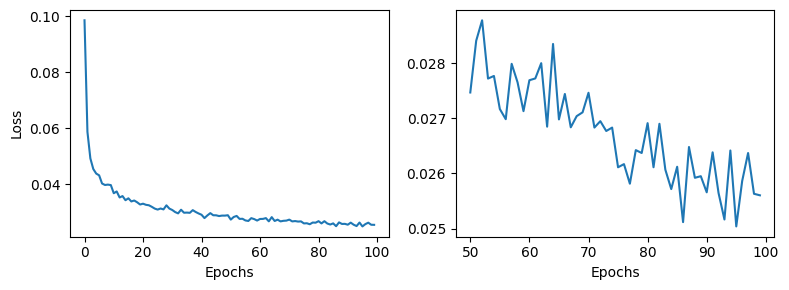

In [12]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.plot(np.array(loss)) 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(np.arange(len(loss)-50, len(loss)), np.array(loss)[-50:])
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.tight_layout()
plt.show()

### Generate new samples

In [14]:
# sample from latent space
n = 24
z = generate(unet_model, n, temp=.9)

# rescale
z = jnp.clip((D_stdv * z) + D_mean, 0., 255.)

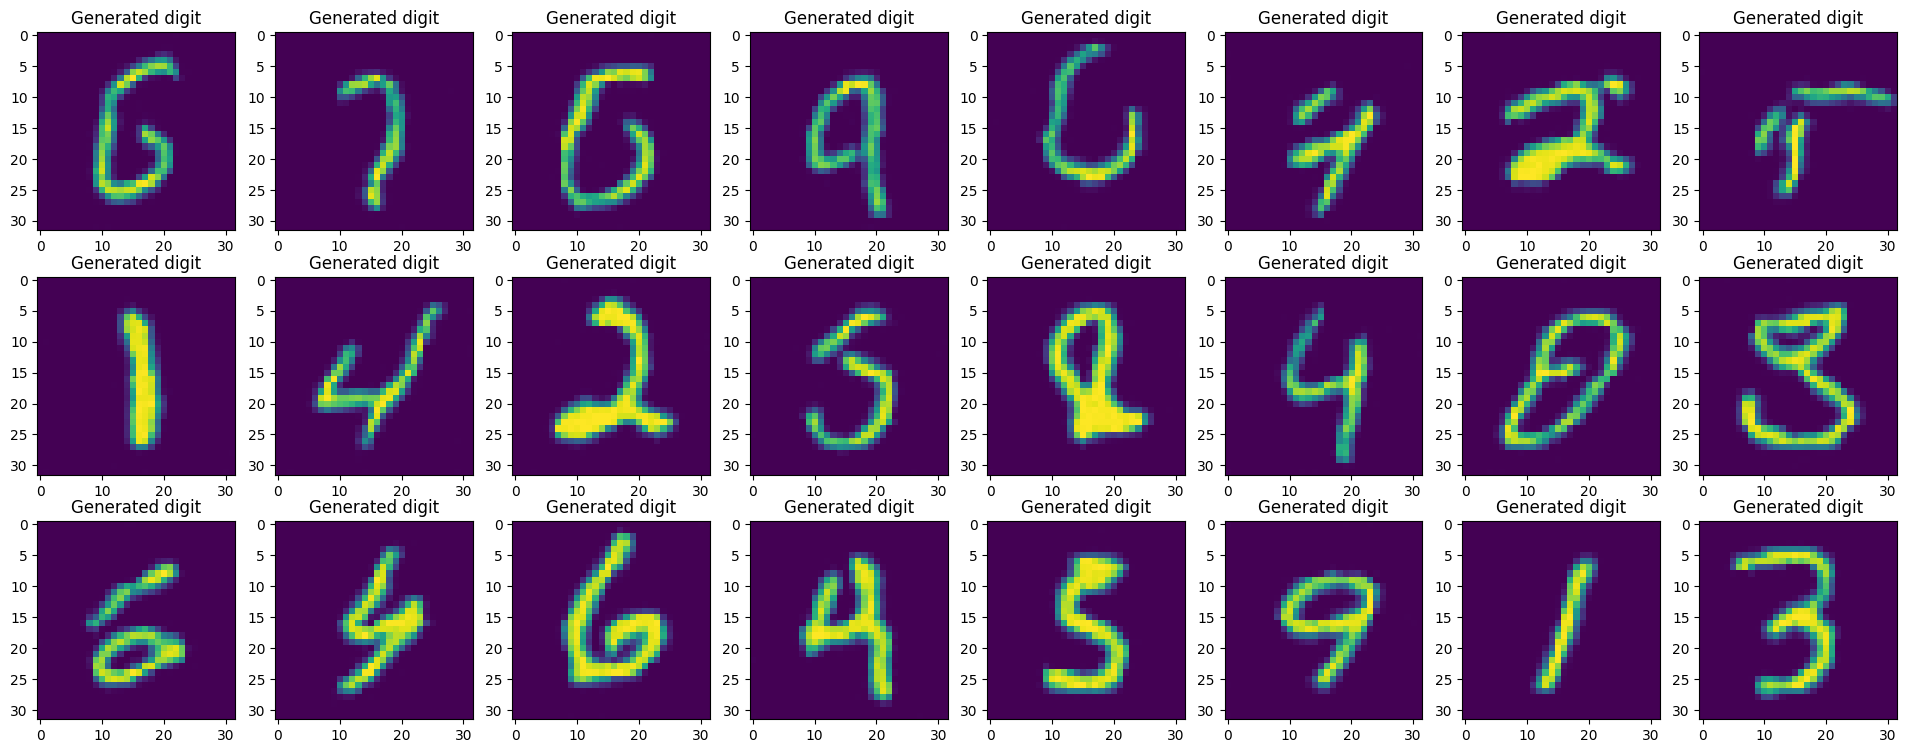

In [15]:
plt.figure(figsize=(3*8, 3*3))

for i, z_i in enumerate(z):

    plt.subplot(3, 8, i+1)
    plt.imshow(z_i)
    plt.title("Generated digit")
plt.show()